In [3]:
# basic libraries
import os
from copy import deepcopy

# import laspy
import laspy
from laspy import file

# import pdal (for manipulating and compressing LAS files)
# import pdal
# import json

# import libraries for managing and plotting data
import numpy as np
import matplotlib.pyplot as plt

# import image libraries
import PIL
from PIL import ImageMath

# import data frame libraries
import pandas as pd

# import math and stats libraries
import statsmodels.api as sm   # if using within jupyter notebook
# import statsmodels as sm   # if using OUTSIDE of jupyter notebook

# use numba library to speed up timing
# from numba import jit
# _numba_settings = {'nopython': True, 'nogil': False, 'fastmath': True}

In [4]:
class sfmpts(object):
    def __init__(self, lasfile):
        self.file_header = lasfile.header
        self.x = lasfile.X
        self.y = lasfile.Y
        self.z = lasfile.Z
        self.r = lasfile.red
        self.g = lasfile.green
        self.b = lasfile.blue
    
    def normRGB(self, minval=0, maxval=1, normrange=[0,1000]):
        if not minval==0: minval = np.amin(self)
        if not maxval==1: maxval = np.amax(inarr)
        self.norminarr = (normrange[1]-normrange[0])*np.divide((inarr-minval), (maxval-minval), out=np.zeros_like(inarr), where=(maxval-minval)!=0)-normrange[0]
    

In [5]:
'''
Function to convert an array to numpy.float32 type.
'''
def arr2float32(inarrlist):
    for inarr in inarrlist:
        if inarr.dtype != np.float32:
            inarr = inarr.astype(np.float32)
'''
Function to convert an array to a specific numeric type.
'''
def arr2float(inarrlist, targetdtype='float32'):
    for inarr in inarrlist:
        if targetdtype=='float32':
            if inarr.dtype != np.float32:
                inarr = inarr.astype(np.float32)
        elif targetdtype=='float64':
            if inarr.dtype != np.float64:
                inarr = inarr.astype(np.float64)
        elif targetdtype=='float16':
            if inarr.dtype != np.float16:
                inarr = inarr.astype(np.float16)

'''
Normalize values in the input array with the specified min and max values to the output range normrange[].
'''
def normdat(inarr, minval=0, maxval=65535, normrange=[0,1]):
    arr2float(inarr, targetdtype='float32')
    if minval!=0:
        minval = np.amin(inarr)
    if maxval!=65535:
        maxval = np.amax(inarr)
    norminarr = (normrange[1]-normrange[0])*np.divide((inarr-minval), (maxval-minval), out=np.zeros_like(inarr), where=(maxval-minval)!=0, casting='unsafe')-normrange[0]
    return np.asarray(norminarr)

'''
Normalize each band by R+G+B.
'''
def normRGB(inarr, Rband, Gband, Bband):
    arr2float([inarr,Rband,Gband,Bband], targetdtype='float32')
    normRGB = np.divide(inarr, (Rband+Gband+Bband), 
                        out=np.zeros_like(inarr), 
                        where=(Rband+Gband+Bband)!=0)
    return np.asarray(normRGB)

'''
Single function to normalize all bands

This function combines 'normdat' and 'normRGB' to operate
on multiple bands, instead of the 'normRGB' function which
only operates on a single band.
'''
def normBands(Rband, Gband, Bband, depth=16):
    # ensure that bands are converted to 32-bit float
    Rband,Gband,Bband = arr2float([Rband,Gband,Bband], targetdtype='float32')
    # check band depth
    if depth==16:
        rmin,rmax,gmin,gmax,bmin,bmax = 0,65536,0,65536,0,65536
    elif depth==8:
        rmin,rmax,gmin,gmax,bmin,bmax = 0,255,0,255,0,2550
    else:
        print("ERROR: bit-depth must be 8 or 16.")
        quit()
    # normalize bands indivudally first
    rn = normdat(Rband, rmin, rmax)
    gn = normdat(Gband, gmin, gmax)
    bn = normdat(Bband, bmin, bmax)
    # then normalize one band by all others
    Rnormalized = np.divide(rn, (rn+gn+bn), 
                        out=np.zeros_like(rn), 
                        where=(rn+gn+bn)!=0)
    Gnormalized = np.divide(gn, (rn+gn+bn), 
                        out=np.zeros_like(gn), 
                        where=(rn+gn+bn)!=0)
    Bnormalized = np.divide(bn, (rn+gn+bn), 
                        out=np.zeros_like(bn), 
                        where=(rn+gn+bn)!=0)
    return np.asarray(Rnormalized), np.asarray(Gnormalized), np.asarray(Bnormalized)

'''
Get the minimum and maximum values for each band.
'''
def getminmax(rbands,gbands,bbands):
    rmn,rmx = 99999,-99999
    gmn,gmx = 99999,-99999
    bmn,bmx = 99999,-99999
    for rb in rbands:
        if np.amin(rb)<rmn: rmn=np.amin(rb)
        if np.amax(rb)>rmx: rmx=np.amax(rb)
    for gb in gbands:
        if np.amin(gb)<gmn: gmn=np.amin(gb)
        if np.amax(gb)>gmx: gmx=np.amax(gb)
    for bb in bbands:
        if np.amin(bb)<bmn: bmn=np.amin(bb)
        if np.amax(bb)>bmx: bmx=np.amax(bb)
    return rmn, rmx, gmn, gmx, bmn, bmx

'''
Otsu's thresholding function

Function is adapted from the following reference:
    Otsu, N. A threshold selection method from gray level histogram. IEEE Trans. Syst. Man Cybern. 1979, 9, 66–166.

The source for the code block is:
    https://stackoverflow.com/questions/48213278/implementing-otsu-binarization-from-scratch-python
     NOTE: The original answer does not include intensity. However, the follow-up answer (see the second
     code block) DOES include intensity in the computation of a threshold.
     Since we are trying to adapt this approach to only work with vegetation indices, we do not need to
     include the recorded intensity when thresholding.
 '''
# def otsu(gray):  # DOES NOT INCLUDE INTENSITY
#     pixel_number = gray.shape[0] * gray.shape[1]
#     mean_weigth = 1.0/pixel_number
#     his, bins = np.histogram(gray, np.array(range(0, 256)))  # assumes 8-bit color depth
#     his, bins = np.histogram(gray, np.array(range(0, 65536)))  # assumes 16-bit color depth
#     final_thresh = -1
#     final_value = -1
#     for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
#         Wb = np.sum(his[:t]) * mean_weigth
#         Wf = np.sum(his[t:]) * mean_weigth
#         # compute the mean of each distribution
#         mub = np.mean(his[:t])
#         muf = np.mean(his[t:])
#         # compute the threshold value
#         value = Wb * Wf * (mub - muf) ** 2
#         # for debugging
# #         print("Wb", Wb, "Wf", Wf)
# #         print("t", t, "value", value)
#         # if the new value is greater than the starting threshold value, update the final_value
#         if value > final_value:
#             final_thresh = t
#             final_value = value
#     final_img = gray.copy()
#     print(final_thresh)
#     final_img[gray > final_thresh] = 255
#     final_img[gray < final_thresh] = 0
#     return final_img
# def otsu(gray):  # INCLUDES INTENSITY
#     pixel_number = gray.shape[0] * gray.shape[1]
#     mean_weight = 1.0/pixel_number
#     his, bins = np.histogram(gray, np.arange(0,256))  # assumes 8-bit color depth
# #     his, bins = np.histogram(gray, np.arange(0,65536))  # assumes 16-bit color depth
#     final_thresh = -1
#     final_value = -1
#     intensity_arr = np.arange(256)
#     for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
#         pcb = np.sum(his[:t])
#         pcf = np.sum(his[t:])
#         Wb = pcb * mean_weight
#         Wf = pcf * mean_weight
#         # compute the mean of the intensity multiplied by the histogram values
#         mub = np.sum(intensity_arr[:t]*his[:t]) / float(pcb)
#         muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)
# #         print mub, muf  # for debugging
#         value = Wb * Wf * (mub - muf) ** 2
#         # if the new value is greater than the starting threshold value, update the final_value
#         if value > final_value:
#             final_thresh = t
#             final_value = value
#     final_img = gray.copy()
#     print(final_thresh)
#     final_img[gray > final_thresh] = 255
#     final_img[gray < final_thresh] = 0
#     return final_img

'''
PURPOSE:
    Function to read in an array (combined from two training class histograms) and find a threshold value that
    maximizes the interclass variability.

RETURN:
    Returns a single threshold value.
'''
def otsu_getthresh(gray, rmin, rmax, nbins):
    num_pts = len(gray)
    mean_weigth = 1.0/num_pts
    his,bins = np.histogram(gray, np.arange(rmin.astype(np.float), rmax.astype(np.float), (rmax.astype(np.float)-rmin.astype(np.float))/nbins))
    final_thresh = -1
    final_value = -1
    for t in range(1,len(bins)-1):
#         print('bin {}'.format(t))
#         print('  his[:t] = {}'.format(his[:t]))
#         print('  his[t:] = {}'.format(his[t:]))
        Wb = np.sum(his[:t]) * mean_weigth
        Wf = np.sum(his[t:]) * mean_weigth
#         print('  Wb = {}'.format(Wb))
#         print('  Wf = {}'.format(Wf))
        mub = np.mean(his[:t])
        muf = np.mean(his[t:])
#         print('  mub = {}'.format(muf))
#         print('  muf = {}'.format(muf))
        value = Wb * Wf * (mub - muf) ** 2
        if value > final_value:
            final_thresh = bins[t]
            final_value = value
    print('Final Threshold Returned = {}'.format(final_thresh))
    return final_thresh

'''
PURPOSE:
    Function to apply a previously extracted threshold value to a new numpy array.

RETURN:
    Returns a copy of the input point cloud reclassed using the provided threshold and updated class values.
    (i.e. numpy array)
'''
def otsu_appthresh(inpts, vegidxarr, veg_noveg_thresh, reclasses=[2,4]):
    final_pts = deepcopy(inpts)
    print('Original Classes: {}'.format(final_pts))
    final_pts[vegidxarr > veg_noveg_thresh] = reclasses[1]
    final_pts[vegidxarr < veg_noveg_thresh] = reclasses[0]
    print('UPDATED Classes: {}'.format(final_pts))
    return final_pts.astype(np.int)

'''
PURPOSE:
    Combine two input arrays without changing their values. This function utilizes pandas to combine the
    arrays without changing any array values.
    
RETURN:
    Returns a single combined numpy array containing the two input numpy arrays.

NOTES:
    Using pandas DataFrames improves performance over solely using numpy arrays:
        mergehist() with Pandas concat() (i.e. first function):       10 loops, best of 3: 19.8 ms per loop
        mergehist() with Numpy concatenate() (i.e. second function):  100 loops, best of 3: 19.4 ms per loop
'''
def mergehist(vegarr, novegarr, plothist=True):
    df = pd.DataFrame(vegarr)  # Two normal distributions
    df2 = pd.DataFrame(novegarr)
    df_merged = pd.concat([df, df2], ignore_index=True)
    return np.array(df_merged.values)
    if plothist:
        # weights
        df_weights = np.ones_like(df.values) / len(df_merged)
        df2_weights = np.ones_like(df2.values) / len(df_merged)
        df_merged_weights = np.ones_like(df_merged.values) / len(df_merged)
        # set plot range ()
        plt_range = (df_merged.values.min(), df_merged.values.max())
        fig,ax = plt.subplots()
        ax.hist(df.values, bins=1000, weights=df_weights, color='black', histtype='step', label='vegarr', range=plt_range)
        ax.hist(df2.values, bins=1000, weights=df2_weights, color='green', histtype='step', label='novegarr', range=plt_range)
        ax.hist(df_merged.values, bins=1000, weights=df_merged_weights, color='red', histtype='step', label='Combined', range=plt_range)
        # set plot margins and display parameters
        ax.margins(0.05)
        ax.set_ylim(bottom=0)
        ax.set_xlim([np.amin(df_merged.values), np.amax(df_merged.values)])
        plt.legend(loc='upper right')

In [6]:
# =============================================================================
# Function for geographic coordinates
# =============================================================================
def scale_dims(las_file):
    # SCALE X dimension
    # create an empty numpy array to store converted values
    out_dat = np.empty(shape=(6, int(las_file.__len__())))
    x_dimension = las_file.X
    scale = las_file.header.scale[0]
    offset = las_file.header.offset[0]
    newrow = x_dimension*scale + offset
    out_dat[0] = newrow
    # SCALE Y dimension
    y_dimension = las_file.Y
    scale = las_file.header.scale[1]
    offset = las_file.header.offset[1]
    newrow = y_dimension*scale + offset
    out_dat[1] = newrow
    # SCALE Z dimension
    z_dimension = las_file.Z
    scale = las_file.header.scale[2]
    offset = las_file.header.offset[2]
    newrow = z_dimension*scale + offset
    out_dat[2] = newrow
    out_dat[3] = las_file.red
    out_dat[4] = las_file.green
    out_dat[5] = las_file.blue
    return(out_dat)

VEGETATION INDICES

In [7]:
def vegidx(lasfileobj, r,g,b, indices='all'):
    #print("X length = {}".format(len(ptgeom[0])))  # FOR DEBUGGING
    #print("Y length = {}".format(len(ptgeom[1])))  # FOR DEBUGGING
    #print("Red length = {}".format(len(lasfileobj.red)))  # FOR DEBUGGING
    pdindex,pdindexnames,minarr,maxarr = [],[],[],[]
    if indices=='all' or indices=='exr' or indices=='exgr':
        # Excess Red (ExR)
        #    Meyer, G.E.; Neto, J.C. Verification of color vegetation indices for automated crop imaging applications.
        #    Comput. Electron. Agric. 2008, 63, 282–293.
        exr = 1.4*b-g
        pdindex.append([exr])
        pdindexnames.append('exr')
    if indices=='all' or indices=='exg' or indices=='exgr':
        # Excess Green (ExG)
        #    Woebbecke, D.M.; Meyer, G.E.; Von Bargen, K.; Mortensen, D.A. Color Indices forWeed Identification Under
        #    Various Soil, Residue, and Lighting Conditions. Trans. ASAE 1995, 38, 259–269.
        exg = 2*g-r-b
        pdindex.append([exg])
        pdindexnames.append('exg')
    if indices=='all' or indices=='exb':
        # Excess Blue (ExB)
        #    Mao,W.;Wang, Y.;Wang, Y. Real-time detection of between-row weeds using machine vision. In Proceedings
        #    of the 2003 ASAE Annual Meeting; American Society of Agricultural and Biological Engineers, Las Vegas,
        #    NV, USA, 27–30 July 2003.
        exb = 1.4*r-g
        pdindex.append([exb])
        pdindexnames.append('exb')
    if indices=='all' or indices=='exgr':
        # Excess Green minus R (ExGR)
        #    Neto, J.C. A combined statistical-soft computing approach for classification and mapping weed species in
        #    minimum -tillage systems. Ph.D. Thesis, University of Nebraska – Lincoln, Lincoln, NE, USA, August 2004.
        exgr = exg-exr
        pdindex.append([exgr])
        pdindexnames.append('exgr')
    if indices=='all' or indices=='ngrdi':
        # calculate Normal Green-Red Difference Index (NGRDI)
        #    Tucker, C.J. Red and photographic infrared linear combinations for monitoring vegetation. Remote Sens.
        #    Environ. 1979, 8, 127–150.
        ngrdi = np.divide((g-r), (r+g), out=np.zeros_like((g-r)), where=(g+r)!=0)
        pdindex.append([ngrdi])
        pdindexnames.append('ngrdi')
    if indices=='all' or indices=='mgrvi':
        # Modified Green Red Vegetation Index (MGRVI)
        #    Tucker, C.J. Red and photographic infrared linear combinations for monitoring vegetation. Remote Sens.
        #    Environ. 1979, 8, 127–150.
        mgrvi = np.divide((np.power(g,2)-np.power(r,2)), (np.power(r,2)+np.power(g,2)), out=np.zeros_like((g-r)), where=(np.power(g,2)+np.power(r,2))!=0)
        pdindex.append([mgrvi])
        pdindexnames.append('mgrvi')
    if indices=='all' or indices=='gli':
        # Green Leaf Index (GLI)
        #    Louhaichi, M.; Borman, M.M.; Johnson, D.E. Spatially located platform and aerial photography for
        #    documentation of grazing impacts on wheat. Geocarto Int. 2001, 16, 65–70.
        gli = np.divide(2*g-r-b, 2*g+r+b, out=np.zeros_like((2*g-r-b)), where=(2*g+r+b)!=0)
        pdindex.append([gli])
        pdindexnames.append('gli')
    if indices=='all' or indices=='rgbvi':
        # Red Green Blue Vegetation Index (RGBVI)
        #    Bendig, J.; Yu, K.; Aasen, H.; Bolten, A.; Bennertz, S.; Broscheit, J.; Gnyp, M.L.; Bareth, G. Combining
        #    UAV-based plant height from crop surface models, visible, and near infrared vegetation indices for biomass
        #    monitoring in barley. Int. J. Appl. Earth Obs. Geoinf. 2015, 39, 79–87.
        rgbvi = np.divide((np.power(g,2)-b*r), (np.power(g,2)+b*r), out=np.zeros_like((np.power(g,2)-b*r)), where=(np.power(g,2)+b*r)!=0)
        pdindex.append([rgbvi])
        pdindexnames.append('rgbvi')
    if indices=='all' or indices=='ikaw':
        # Kawashima Index (IKAW)
        #    Kawashima, S.; Nakatani, M. An algorithm for estimating chlorophyll content in leaves using a video camera.
        #    Ann. Bot. 1998, 81, 49–54.
        ikaw = np.divide((r-b), (r+b), out=np.zeros_like((r-b)), where=(r+b)!=0)
        pdindex.append([ikaw])
        pdindexnames.append('ikaw')
    if indices=='all' or indices=='gla':
        # Green Leaf Algorithm (GLA)
        #    Louhaichi, M.; Borman, M.M.; Johnson, D.E. Spatially located platform and aerial photography for
        #    documentation of grazing impacts on wheat. Geocarto Int. 2001, 16, 65–70.
        gla = np.divide((2*g-r-b), (2*g+r+b), out=np.zeros_like((2*g-r-b)), where=(2*g+r+b)!=0)
        pdindex.append([gla])
        pdindexnames.append('gla')
    # Use vegetation indices names as the index (row labels) for the dataframe
    # FIRST, create the data frame with the raw index values
    outdat = pd.DataFrame(pdindex,
                          index=pdindexnames,
                          columns=['vals'])
    #print("Outdat length = {}".format(len(outdat['vals']['exg'])))  # FOR DEBUGGING
    return outdat

# def vegidx(las_obj, r,g,b, indices='all'):
#     pdindex,pdindexnames,minarr,maxarr = [],[],[],[]
#     if indices=='all' or indices=='exr' or indices=='exgr':
#         # Excess Red (ExR)
#         #    Meyer, G.E.; Neto, J.C. Verification of color vegetation indices for automated crop imaging applications.
#         #    Comput. Electron. Agric. 2008, 63, 282–293.
#         exr = 1.4*b-g
#         pdindex.append([exr])
#         pdindexnames.append('exr')
#         minarr.append(-1.0)
#         maxarr.append(1.4)
#     if indices=='all' or indices=='exg' or indices=='exgr':
#         # Excess Green (ExG)
#         #    Woebbecke, D.M.; Meyer, G.E.; Von Bargen, K.; Mortensen, D.A. Color Indices forWeed Identification Under
#         #    Various Soil, Residue, and Lighting Conditions. Trans. ASAE 1995, 38, 259–269.
#         exg = 2*g-r-b
#         pdindex.append([exg])
#         pdindexnames.append('exg')
#         minarr.append(-1.0)
#         maxarr.append(2.0)
#     # if indices=='all' or indices=='vari':
#     #     # Visible Atmospherically Resistant Index (VARI)
#     #     #    Gitelson, A.A.; Kaufman, Y.J.; Stark, R.; Rundquist, D. Novel algorithms for remote estimation of vegetation
#     #     #    fraction. Remote Sens. Environ. 2002, 80, 76–87.
#     #     vari = np.divide((g-r), (g+r-b), out=np.zeros_like(g-r), where=(g+r-b)!=0)
#     #     pdindex.append([vari])
#     #     pdindexnames.append('vari')
#     # if indices=='all' or indices=='wi':
#     #     # Woebbecke Index (WI)
#     #     #    Woebbecke, D.M.; Meyer, G.E.; Von Bargen, K.; Mortensen, D.A. Color Indices forWeed Identification Under
#     #     #    Various Soil, Residue, and Lighting Conditions. Trans. ASAE 1995, 38, 259–269.
#     #     wi = np.divide((g-b), abs(r-g), out=np.zeros_like((g-b)), where=((r-g)!=0)&((g-b)!=0))
#     #     pdindex.append([wi])
#     #     pdindexnames.append('wi')
#     if indices=='all' or indices=='exb':
#         # Excess Blue (ExB)
#         #    Mao,W.;Wang, Y.;Wang, Y. Real-time detection of between-row weeds using machine vision. In Proceedings
#         #    of the 2003 ASAE Annual Meeting; American Society of Agricultural and Biological Engineers, Las Vegas,
#         #    NV, USA, 27–30 July 2003.
#         exb = 1.4*r-g
#         pdindex.append([exb])
#         pdindexnames.append('exb')
#         minarr.append(-1.0)
#         maxarr.append(1.4)
#     if indices=='all' or indices=='exgr':
#         # Excess Green minus R (ExGR)
#         #    Neto, J.C. A combined statistical-soft computing approach for classification and mapping weed species in
#         #    minimum -tillage systems. Ph.D. Thesis, University of Nebraska – Lincoln, Lincoln, NE, USA, August 2004.
#         exgr = exg-exr
#         pdindex.append([exgr])
#         pdindexnames.append('exgr')
#         minarr.append(-2.4)
#         maxarr.append(3.0)
#     # if indices=='all' or indices=='cive':
#     #     # calculate Color Index of Vegetation Extraction (CIVE)
#     #     cive = 0.4412*r-0.811*g+0.385*b+18.78745
#     #     pdindex.append([cive])
#     #     pdindexnames.append('cive')
#     if indices=='all' or indices=='ngrdi':
#         # calculate Normal Green-Red Difference Index (NGRDI)
#         #    Tucker, C.J. Red and photographic infrared linear combinations for monitoring vegetation. Remote Sens.
#         #    Environ. 1979, 8, 127–150.
#         ngrdi = np.divide((g-r), (r+g), out=np.zeros_like((g-r)), where=(g+r)!=0)
#         pdindex.append([ngrdi])
#         pdindexnames.append('ngrdi')
#         minarr.append(-1.0)
#         maxarr.append(1.0)
#     if indices=='all' or indices=='mgrvi':
#         # Modified Green Red Vegetation Index (MGRVI)
#         #    Tucker, C.J. Red and photographic infrared linear combinations for monitoring vegetation. Remote Sens.
#         #    Environ. 1979, 8, 127–150.
#         mgrvi = np.divide((np.power(g,2)-np.power(r,2)), (np.power(r,2)+np.power(g,2)), out=np.zeros_like((g-r)), where=(np.power(g,2)+np.power(r,2))!=0)
#         pdindex.append([mgrvi])
#         pdindexnames.append('mgrvi')
#         minarr.append(-1.0)
#         maxarr.append(1.0)
#     if indices=='all' or indices=='gli':
#         # Green Leaf Index (GLI)
#         #    Louhaichi, M.; Borman, M.M.; Johnson, D.E. Spatially located platform and aerial photography for
#         #    documentation of grazing impacts on wheat. Geocarto Int. 2001, 16, 65–70.
#         gli = np.divide(2*g-r-b, 2*g+r+b, out=np.zeros_like((2*g-r-b)), where=(2*g+r+b)!=0)
#         pdindex.append([gli])
#         pdindexnames.append('gli')
#         minarr.append(-1.0)
#         maxarr.append(1.0)
#     if indices=='all' or indices=='rgbvi':
#         # Red Green Blue Vegetation Index (RGBVI)
#         #    Bendig, J.; Yu, K.; Aasen, H.; Bolten, A.; Bennertz, S.; Broscheit, J.; Gnyp, M.L.; Bareth, G. Combining
#         #    UAV-based plant height from crop surface models, visible, and near infrared vegetation indices for biomass
#         #    monitoring in barley. Int. J. Appl. Earth Obs. Geoinf. 2015, 39, 79–87.
#         rgbvi = np.divide((np.power(g,2)-b*r), (np.power(g,2)+b*r), out=np.zeros_like((np.power(g,2)-b*r)), where=(np.power(g,2)+b*r)!=0)
#         pdindex.append([rgbvi])
#         pdindexnames.append('rgbvi')
#         minarr.append(-1.0)
#         maxarr.append(1.0)
#     if indices=='all' or indices=='ikaw':
#         # Kawashima Index (IKAW)
#         #    Kawashima, S.; Nakatani, M. An algorithm for estimating chlorophyll content in leaves using a video camera.
#         #    Ann. Bot. 1998, 81, 49–54.
#         ikaw = np.divide((r-b), (r+b), out=np.zeros_like((r-b)), where=(r+b)!=0)
#         pdindex.append([ikaw])
#         pdindexnames.append('ikaw')
#         minarr.append(-1.0)
#         maxarr.append(1.0)
#     if indices=='all' or indices=='gla':
#         # Green Leaf Algorithm (GLA)
#         #    Louhaichi, M.; Borman, M.M.; Johnson, D.E. Spatially located platform and aerial photography for
#         #    documentation of grazing impacts on wheat. Geocarto Int. 2001, 16, 65–70.
#         gla = np.divide((2*g-r-b), (2*g+r+b), out=np.zeros_like((2*g-r-b)), where=(2*g+r+b)!=0)
#         pdindex.append([gla])
#         pdindexnames.append('gla')
#         minarr.append(-1.0)
#         maxarr.append(1.0)
#     # if indices=='all' or indices=='vega':
#     #     # Vegetativen (vega)
#     #     #    Hague, T.; Tillett, N.D.; Wheeler, H. Automated crop and weed monitoring in widely spaced cereals. Precis.
#     #     #    Agric. 2006, 7, 21–32.
#     #     vega = np.divide(g, (np.power(r,0.667)*np.power(b,(1-0.667))), out=np.zeros_like(g), where=(np.power(r,0.667)*np.power(b,(1-0.667)))!=0)
#     #     pdindex.append([vega])
#     #     pdindexnames.append('vega')
#     # if indices=='all' or indices=='com':
#     #     # calculate a combined (COM) vegetation index from:
#     #     #    Yang, W., Wang, S., Zhao, X., Zhang, J., and Feng, J. (2015). Greenness identification based on
#     #     #    HSV decision tree. Information Processing in Agriculture 2, 149–160. doi:10.1016/j.inpa.2015.07.003.
#     #     com = 0.25*exg+0.30*exgr+0.33*cive+0.12*vega
#     #     pdindex.append([com])
#     #     pdindexnames.append('com')
#     # Use vegetation indices names as the index (row labels) for the dataframe
#     # FIRST, create the data frame with the raw index values
#     outdat = pd.DataFrame(pdindex,
#                           index=pdindexnames,
#                           columns=['vals'])
#     outdat['minidxpos'] = minarr   # then add a new column with the minimum possible index values
#     outdat['maxidxpos'] = maxarr   # then add a new column with the maximum possible index values
#     return outdat

In [8]:
'''
The following are a collection of functions to compute statistics
for the computed vegetation indices.
'''
def addstats(intable, values_column='vals'):
    minar,maxar,medar,meanar,stdar = [],[],[],[],[]
    for index,row in intable.iterrows():
        minar.append(np.amin(row[values_column]))
        maxar.append(np.amax(row[values_column]))
        medar.append(np.median(row[values_column]))
        meanar.append(np.mean(row[values_column]))
        stdar.append(np.std(row[values_column]))
    intable['min'] = minar
    intable['max'] = maxar
    intable['med'] = medar
    intable['mean'] = meanar
    intable['std'] = stdar
    del([minar,maxar,medar,meanar,stdar])

def computeM_singletable(intable):
    '''
    Compute the M-statistic to compare all rows in the input table.
    From:
        Kaufman, Y.J.; Remer, L.A. Detection of forests using mid-IR reflectance: An application for aerosol studies.
        IEEE Trans. Geosci. Remote Sens. 1994, 32, 672–683.
    '''
    outtable = pd.DataFrame(0.00, index=list(intable.index),
                            columns=list(intable.index))
    for i in list(intable.index):
        for j in list(intable.index):
            if (i!=j)&(intable['mean'][i]!=intable['mean'][j]):
                outtable[i][j] = (intable['mean'][i]-intable['mean'][j])/(intable['std'][i]-intable['std'][j])
    return outtable

def computeM(intable1, intable2, writeout=''):
    '''
    Compute the M-statistic to compare all rows in the input table.
    From:
        Kaufman, Y.J.; Remer, L.A. Detection of forests using mid-IR reflectance: An application for aerosol studies.
        IEEE Trans. Geosci. Remote Sens. 1994, 32, 672–683.
    '''
    outtable = pd.DataFrame(0.00, index=list(intable1.index), columns=['M-statistic'])
    for i in list(intable1.index):
        for j in list(intable2.index):
            if i==j:
                outtable['M-statistic'][i] = (intable1['mean'][i]-intable2['mean'][j])/(intable1['std'][i]-intable2['std'][j])
    if writeout!='':
        outtable.to_csv(str(writeout)+'_veg_noveg_M-statistic.csv')
    return outtable

# def veg_noveg(infile, vegtrain, novegtrain, idxvals, thresh):
#     # open an output file to read and write
#     outfile = file.File('__out.laz',mode='wr',header=indat.header)
#     outfile.points = indat.points  # copy the points from the specified input las/laz file
#     ptclass = deepcopy(indat.classification)  # create a copy of the input points
# def binarization(indat, inthresh):
    

<h1>TESTING WITH IMAGE</h1>

In [17]:
# read the image
fooimg = PIL.Image.open('20180726_IMG_0206.JPG')

# split out the RGB channels and make copies
rimg,gimg,bimg = fooimg.split()
rimgcopy,gimgcopy,bimgcopy = deepcopy(rimg),deepcopy(gimg),deepcopy(bimg)

In [18]:
rimg = np.array(rimg)
gimg = np.array(gimg)
bimg = np.array(bimg)

Rimg = np.divide(rimg, 255)
Gimg = np.divide(gimg, 255)
Bimg = np.divide(bimg, 255)

rimg = np.divide(Rimg, (Rimg+Gimg+Bimg), out=np.zeros_like(Rimg), where=(Rimg+Gimg+Bimg)!=0)
gimg = np.divide(Gimg, (Rimg+Gimg+Bimg), out=np.zeros_like(Gimg), where=(Rimg+Gimg+Bimg)!=0)
bimg = np.divide(Bimg, (Rimg+Gimg+Bimg), out=np.zeros_like(Bimg), where=(Rimg+Gimg+Bimg)!=0)

In [19]:
imgidxs = vegidx(rimg,gimg,bimg)

94
123
118
126
132
124
121
127
126
26
125
127
132


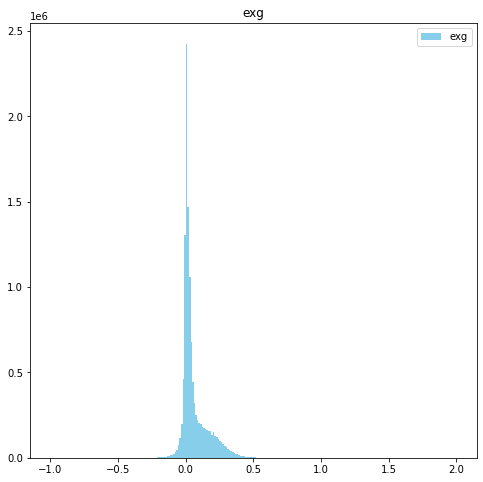

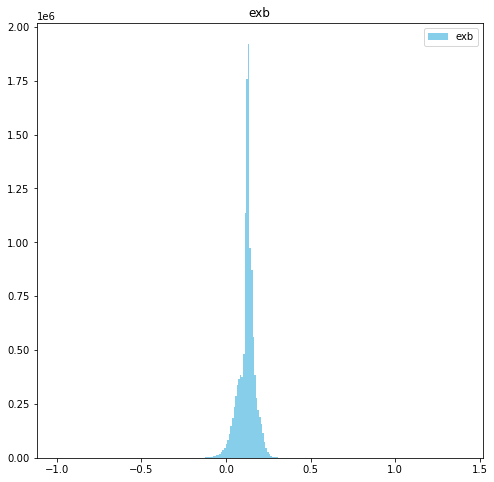

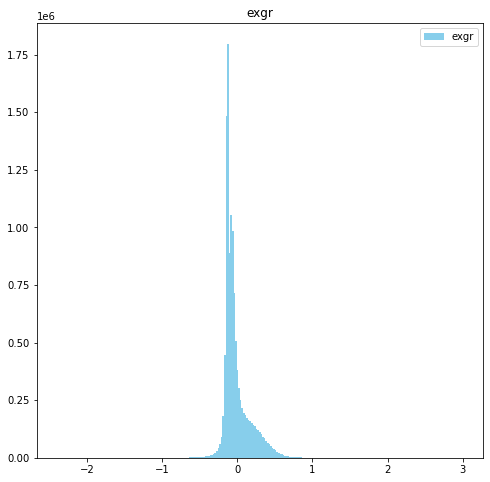

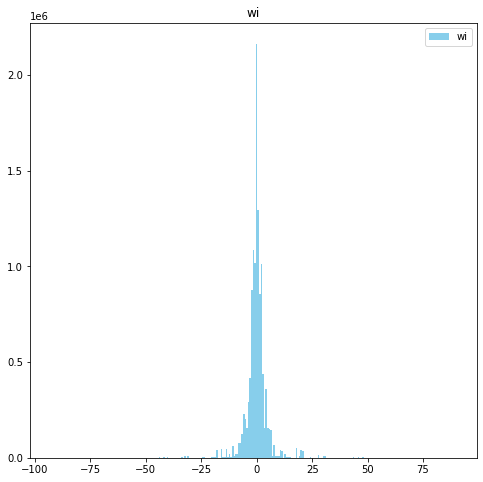

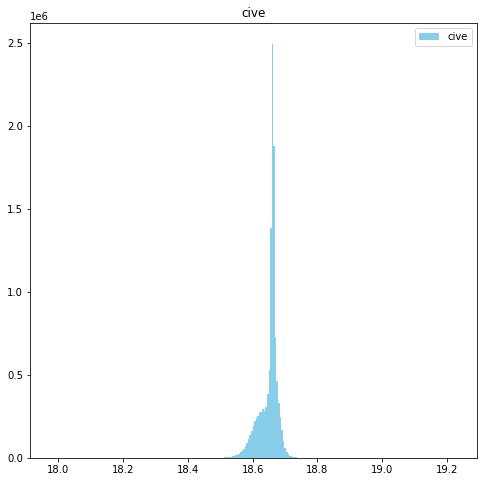

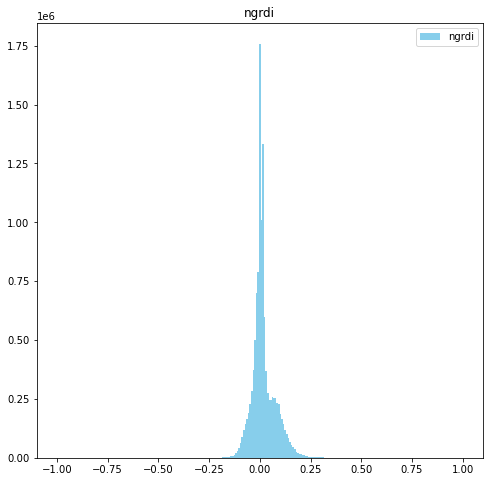

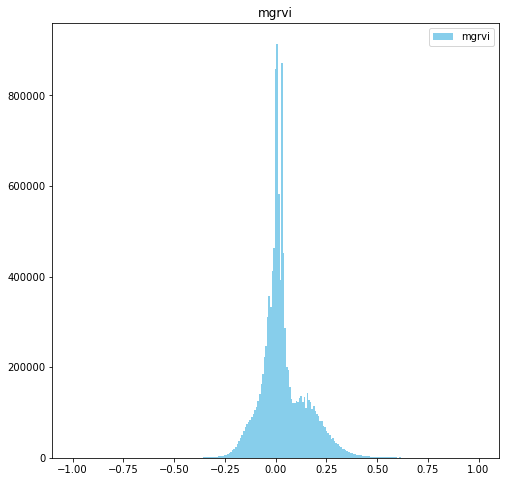

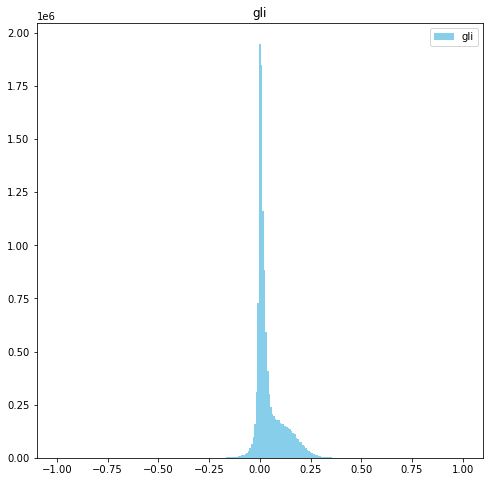

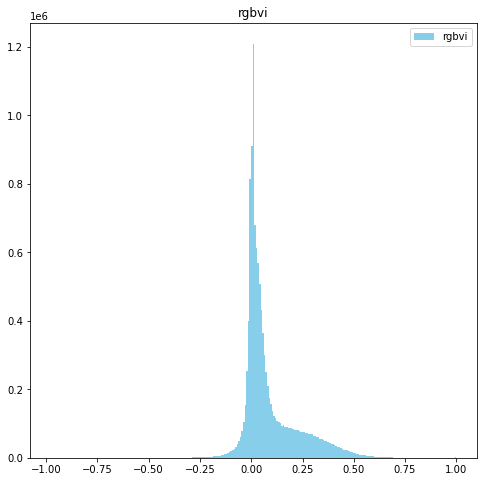

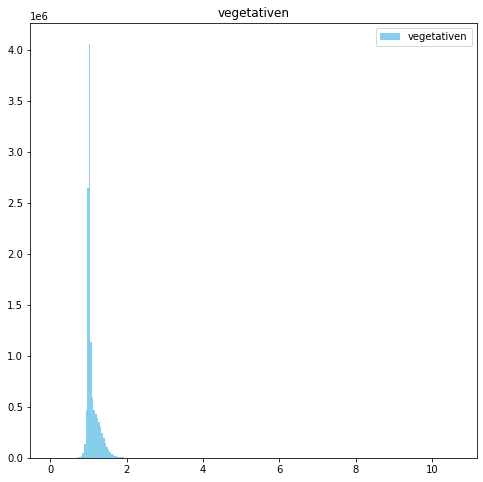

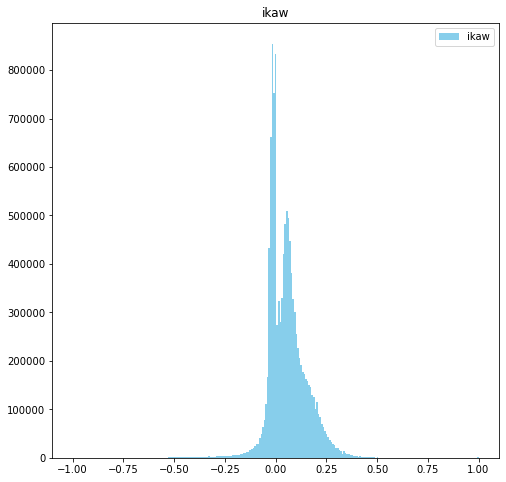

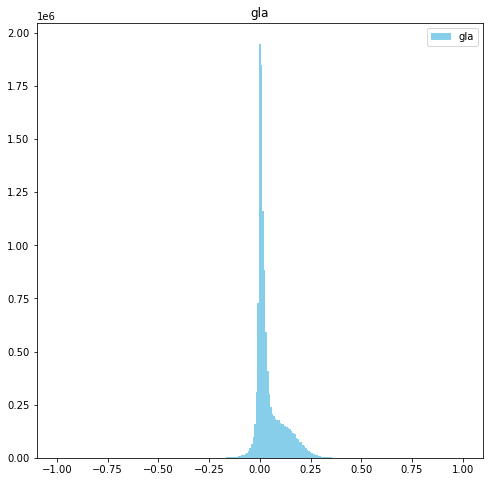

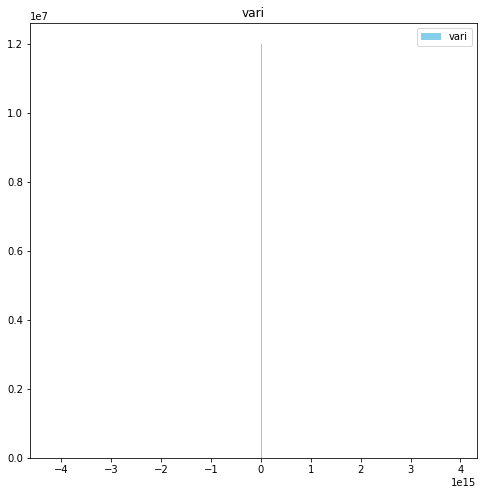

In [20]:
for idx in range(1,len(imgidxs)):
    plt.figure(figsize=(8,8))
    plt.hist(np.array(imgidxs[idx][1]).flatten(), bins=255, color='skyblue', lw=0)
    plt.title(imgidxs[idx][0])
    plt.legend([imgidxs[idx][0]])
    plt.savefig(('20170626_IMG_0112_histogram_'+imgidxs[idx][0]+'.png'))
    
    tmpdat = otsu(normdat(imgidxs[idx][1]))
    tmpimg = PIL.Image.fromarray(tmpdat[0])
    tmpimg.convert('L').save('20170626_IMG_0112_vegindex_'+imgidxs[idx][0]+'_otsu_'+str(tmpdat[1])+'.jpg')

<h1>TESTING WITH POINT CLOUD</h1>

In [9]:
# import tkinter
# from tkinter import Tk
# from tkinter.filedialog import askopenfile
# def getfile(window_title='Select File'):
#     root_win = Tk()  # initialize the tKinter window to get user input
#     root_win.withdraw()
#     root_win.update()
#     file_io = askopenfile(title=window_title)  # get user input for the output directory
#     root_win.destroy()  # destroy the tKinter window
#     if not os.name=='nt':  # if the OS is not Windows, then correct slashes in directory name
#         file.io = ntpath.normpath(file_io)
#     return str(file_io.name)
# '''
# Read in the point clouds (1) to be classified, (2) vegetation sample points, and
# (3) bare earth sample points. Then, print the number of points in each file.
# '''
# # get filenames
# classifyfile = getfile(window_title='Select File to Classify')
# print(classifyfile)
# infile_veg = getfile(window_title='Select Vegetation Training Sample')
# print(infile_veg)
# infile_noveg = getfile(window_title='Select Non-Vegetation Training Sample')
# print(infile_noveg)

# # Read in the complete LAS/LAZ file and the vegetation/no-vegetation LAS/LAZ Files
# print('Reading: {}'.format(classifyfile))
# f = file.File(str(classifyfile),mode='r')
# print('  Point Cloud to Classify: {}'.format(len(f)))
# print('Reading: {}'.format(infile_veg))
# fnoveg = file.File(str(infileveg),mode='r')
# print('  No Vegetation Point Cloud: {}'.format(len(fnoveg)))
# print('Reading: {}'.format(infile_noveg))
# fveg = file.File(str(infile_noveg),mode='r')
# print('  Vegetation ONLY Point Cloud: {}'.format(len(fveg)))

# f = file.File('20180726.laz',mode='r')
# f = file.File('test_dat/20160818.laz',mode='r')
# fnoveg = file.File('test_dat/20160818_noveg.laz',mode='r')
# fveg = file.File('test_dat/20160818_veg.laz',mode='r')

# fnoveg = file.File('test_dat/training_noveg.laz',mode='r')
# fveg = file.File('test_dat/training_veg.laz',mode='r')
fnoveg = file.File('C:/Users/pwernette/OneDrive - DOI/Machine Learning/test_dat/training_noveg.laz',mode='r')
fveg = file.File('C:/Users/pwernette/OneDrive - DOI/Machine Learning/test_dat/training_veg.laz',mode='r')

# print('Sample: '+str(len(f)))
print('No Vegetation sample: '+str(len(fnoveg)))
print('Vegetation ONLY sample: '+str(len(fveg)))

No Vegetation sample: 102724221
Vegetation ONLY sample: 22865766


In [ ]:
np.savez_compressed('pts_noveg.npz', noveg=fnoveg)
np.savez_compressed('pts_veg.npz', veg=fveg)
# root_dir,infilename = os.path.split(f.filename)
# infilename = infilename.split('.')[0]

In [55]:
# extract the R,G,B values of the point clouds
'''
NOTE: Use deepcopy whenever copying variables, as it creates a stand-alone version of the variable and values,
instead of simply referencing back to the original variable and values. Without deepcopy(), modifying a 
"copied object" may actually result in modifying the original object, instead of the copy.

NEED a deepcopy() of each band for normalizing each band (see next code block)
'''
# r,g,b = deepcopy(f.red),deepcopy(f.green),deepcopy(f.blue)
# rcopy,gcopy,bcopy = deepcopy(r),deepcopy(g),deepcopy(b)

rveg,gveg,bveg = deepcopy(fveg.red),deepcopy(fveg.green),deepcopy(fveg.blue)  # vegetation pc
rvcopy,gvcopy,bvcopy = deepcopy(rv),deepcopy(gv),deepcopy(bv)

rno,gno,bno = deepcopy(fnoveg.red),deepcopy(fnoveg.green),deepcopy(fnoveg.blue)  # no veg. pc
rncopy,gncopy,bncopy = deepcopy(rn),deepcopy(gn),deepcopy(bn)

In [ ]:
'''
Extract the minimum and maximum values of the r,g,b bands for all combined point clouds (training and testing).

In this case, since we are dealing with point clouds that have 16-bit color depth, the minimum value possible
is 0 and the maximum value possible is 65,535. If changing from 16-bit color comment out line 10 of this block.
If the color depth is 8-bit, then the minimum and maximum values should be changed to 0 and 255, respectively
by uncommenting line 11 of this block.
'''
# rmin,rmax,gmin,gmax,bmin,bmax = getminmax([rcopy,rvcopy,rncopy],[gcopy,gvcopy,gncopy],[bcopy,bvcopy,bncopy])
# rmin,rmax,gmin,gmax,bmin,bmax = 0,65536,0,65536,0,65536
# rmin,rmax,gmin,gmax,bmin,bmax = 0,255,0,255,0,255
# print the values to screen
# print('R min and max = ({}, {})'.format(rmin,rmax))
# print('G min and max = ({}, {})'.format(gmin,gmax))
# print('B min and max = ({}, {})'.format(bmin,bmax))

'''
Normalize the testing r,g,b values
'''
# r = normRGB(normdat(rcopy,rmin,rmax),normdat(rcopy,rmin,rmax),normdat(gcopy,gmin,gmax),normdat(bcopy,bmin,bmax))
# g = normRGB(normdat(gcopy,gmin,gmax),normdat(rcopy,rmin,rmax),normdat(gcopy,gmin,gmax),normdat(bcopy,bmin,bmax))
# b = normRGB(normdat(bcopy,bmin,bmax),normdat(rcopy,rmin,rmax),normdat(gcopy,gmin,gmax),normdat(bcopy,bmin,bmax))
# plt.figure(figsize=(8,8))
# plt.hist(np.array(r).flatten(), bins=1000, color='red', lw=0, alpha=0.5)
# plt.hist(np.array(g).flatten(), bins=1000, color='green', lw=0, alpha=0.5)
# plt.hist(np.array(b).flatten(), bins=1000, color='blue', lw=0, alpha=0.5)
# plt.show()

'''
Normalize the vegetation training r,g,b values
'''
# rv = normRGB(normdat(rvcopy,rmin,rmax),normdat(rvcopy,rmin,rmax),normdat(gvcopy,gmin,gmax),normdat(bvcopy,bmin,bmax))
# gv = normRGB(normdat(gvcopy,gmin,gmax),normdat(rvcopy,rmin,rmax),normdat(gvcopy,gmin,gmax),normdat(bvcopy,bmin,bmax))
# bv = normRGB(normdat(bvcopy,bmin,bmax),normdat(rvcopy,rmin,rmax),normdat(gvcopy,gmin,gmax),normdat(bvcopy,bmin,bmax))
rn,gn,bn = normBands(fveg.red,fveg.green,fveg.blue)
# plt.figure(figsize=(8,8))
# plt.hist(np.array(rv).flatten(), bins=1000, color='red', lw=0, alpha=0.5)
# plt.hist(np.array(gv).flatten(), bins=1000, color='green', lw=0, alpha=0.5)
# plt.hist(np.array(bv).flatten(), bins=1000, color='blue', lw=0, alpha=0.5)
# plt.show()

'''
Normalize the no-vegetation training r,g,b values
'''
# rn = normRGB(normdat(rncopy,rmin,rmax),normdat(rncopy,rmin,rmax),normdat(gncopy,gmin,gmax),normdat(bncopy,bmin,bmax))
# gn = normRGB(normdat(gncopy,gmin,gmax),normdat(rncopy,rmin,rmax),normdat(gncopy,gmin,gmax),normdat(bncopy,bmin,bmax))
# bn = normRGB(normdat(bncopy,bmin,bmax),normdat(rncopy,rmin,rmax),normdat(gncopy,gmin,gmax),normdat(bncopy,bmin,bmax))
rn,gn,bn = normBands(fnoveg.red,fnoveg.green,fnoveg.blue)
# plt.figure(figsize=(8,8))
# plt.hist(np.array(rn).flatten(), bins=1000, color='red', lw=0, alpha=0.5)
# plt.hist(np.array(gn).flatten(), bins=1000, color='green', lw=0, alpha=0.5)
# plt.hist(np.array(bn).flatten(), bins=1000, color='blue', lw=0, alpha=0.5)
# plt.show()

In [ ]:
'''
Since the r, g, and b values have been normalized all based on the same minimum and maximim values
    AND
Since none of the vegetation indicies use minimum or maximum of any band
    THEN...
Computing the multiple (or individual) vegetation indicies yields the same range of values, regardless
of whether it is a training sample or testing sample (again, assuming the first assumption holds true).
'''
# compute vegetation indicies based on point cloud normalized and scaled rgb values
# vegidx_pts = vegidx(r,g,b, lasfileobj=)
# veg_idx = vegidx(fveg, rv,gv,bv)
noveg_idx = vegidx(fnoveg, rn,gn,bn)
scalepts = scale_dims(fveg)
test = pd.DataFrame([[scalepts[0]],[scalepts[1]],[scalepts[2]],[rv],[gv],[bv]], 
                    columns=['vals'], 
                    index=['x','y','z','r','g','b'])
testmerge = pd.concat([test,vegidx(fveg, rv,gv,bv)])

veg_tmp = pd.DataFrame([no.ones_like(test.to_numpy)])

# print(veg_idx)
# print(noveg_idx)

print(scalepts[0])
print(rv)
print(testmerge)
print(veg_tmp)

In [ ]:
# compute the summary stats (minimum, maximum, median, mean, and standard deviations) of each index
# addstats(vegidx_pts)
addstats(veg_idx)
addstats(noveg_idx)

print(veg_idx)
print(noveg_idx)

In [ ]:
'''
The M-statistic is an approach to identify how well normal distributions of the training classes,
in this case vegetation and no vegetation, are distinguishable from each other. The greater the
difference in distributions, the more differentiable they are from each other, and the greater the
M-statistic will be.

The 'writeout' option is used to write out the file as a CSV.

Using the M-statistic is taken from:
    Mesas-Carrascosa, F.-J., de Castro, A. I., Torres-Sánchez, J., Triviño-Tarradas, P., 
    Jiménez-Brenes, F. M., García-Ferrer, A., et al. (2020). Classification of 3D Point 
    Clouds Using Color Vegetation Indices for Precision Viticulture and Digitizing Applications. 
    Remote Sensing 12, 317. doi:10.3390/rs12020317.
'''
# compute M-statistic for all vegetation indicies
# vegM = computeM(veg_idx, noveg_idx, writeout='20180726')
# print(vegM)

In [22]:
'''
LILLIEFORS TEST FOR NORMAL DISTRIBUTION

Lilliefors test for normality should be run on each distribution to ensure that the values are, in fact, normally
distributed. If they are NOT normally distributed, then Otsu's binarization may not identify an appropriate
threshold value, as values are skewed one direction or the other.

If the returned p-value (2nd return) is below some statistical threshold (e.g. 0.05), then reject Ho
that the input data is normally distributed.
'''
#   
# sm.stats.diagnostic.lilliefors(r, dist='norm')
for i in list(veg_idx.index):
    print('Index: {}'.format(i))
    print('  Vegetation Lilliefors normality test: {}'.format(sm.stats.diagnostic.lilliefors(veg_idx['vals'][i], dist='norm')))
    print('  NO Vegetation Lilliefors normality test: {}'.format(sm.stats.diagnostic.lilliefors(noveg_idx['vals'][i], dist='norm')))

NameError: name 'veg_idx' is not defined

In [8]:
# for i in list(veg_idx.index):
#     print('Index name: {}'.format(i))
veg_idx

NameError: name 'veg_idx' is not defined

In [11]:
'''
Get the index of maximum M-statistic (assuming it provides the greatest opportunity to differentiate vegetation
points from non-vegetation points).

Then, compute the minimum and maximum of the combined index values, which will be used to merge the two training
classes/samples.
'''
# extract index of max value from M-statistic table
# maxidx = vegM[['M-statistic']].idxmax()[0]
maxidx = 'exgr'  # for test purposes, you can uncomment this line and change the index of interest to any other index
print("Differentiable Index: "+str(maxidx))

# get min & max values
# minval = np.amin(np.concatenate((vegidx_pts['vals'][maxidx],veg_idx['vals'][maxidx],noveg_idx['vals'][maxidx])))
# maxval = np.amax(np.concatenate((vegidx_pts['vals'][maxidx],veg_idx['vals'][maxidx],noveg_idx['vals'][maxidx])))
minval = np.amin(np.concatenate((veg_idx['vals'][maxidx],noveg_idx['vals'][maxidx])))
maxval = np.amax(np.concatenate((veg_idx['vals'][maxidx],noveg_idx['vals'][maxidx])))
print('  Index min and max = ({}, {})'.format(minval,maxval))


'''
Combine vegetation index values from vegetation and non-vegetation classes
'''
comboidx = mergehist(veg_idx['vals'][maxidx], noveg_idx['vals'][maxidx])

'''
Compute the appropriate binarization threshold value for veg/no-veg samples using Otsu's thresholding method 
function otsu_getthresh().
'''
bin_thresh = otsu_getthresh(comboidx, minval, maxval, nbins=1000)

Differentiable Index: exgr
  Index min and max = (-1.414117693901062, 3.0)
Final Threshold Returned = -0.0854682680368648


In [14]:
'''
Apply the threshold from the veg/no-veg binarization to another point cloud using the otsu_appthresh() function.
'''
updated_classes = otsu_appthresh(deepcopy(f.classification), vegidx_pts['vals'][maxidx], bin_thresh, reclasses=[2,4])

# clean up memory
del veg_idx, noveg_idx

Original Classes: [18 18 18 ... 18 18 18]
UPDATED Classes: [2 2 2 ... 4 4 4]


In [15]:
'''
Create copy of entire point cloud, update the classification field, and save the LAS/LAZ file.
'''
# extract the base filename from the input sample LAS/LAZ file header
infilename = (os.path.split(f.filename)[-1]).split('.')[0]
# create a new file with an updated name ("_reclass_veg_noveg.laz" has been appended to the filename)
f_out = file.File((infilename+'_reclass_veg_noveg_'+str(maxidx)+'.laz'), mode='w', header=f.header)
# copy the points from the origina file to the new output file
f_out.points = f.points
# update the classification with the computed/binarized classes from the previous code block
f_out.classification = updated_classes
# close the output file
f_out.close()
f.close()

OSError: [Errno 22] Invalid argument: 'C:\\Users\\pwernette\\OneDrive - DOI\\Machine Learning\\20160818_reclass_veg_noveg_exgr.laz'

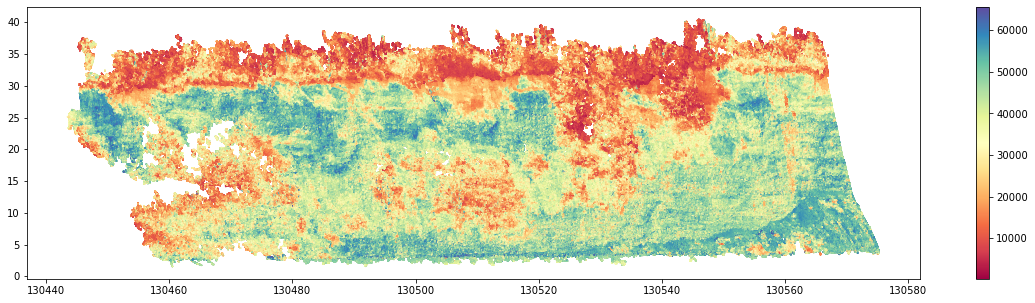

In [514]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 5])
ax = plt.axes()
sc = ax.scatter(f.y, f.z, c=f.intensity ,s=0.1, marker='o', cmap="Spectral")
plt.colorbar(sc)
plt.show()

# %matplotlib inline
# fig = plt.figure(figsize=[20, 5])
# ax = plt.axes(projection='3d')
# sc = ax.scatter(f.x, f.y, f.z, c=f.intensity ,s=0.1, marker='o', cmap="Spectral")
# plt.colorbar(sc)
# plt.show()

<h1>CLIFF MORPHOMETRICS</h1>

GET ORIENTATION

In [117]:
xmin,xmax = np.amin(f.x),np.amax(f.x)
ymin,ymax = np.amin(f.y),np.amax(f.y)
print(xmin,xmax)
print(ymin,ymax)

299152.5350341565 299242.99694826856
130443.45400994716 130575.30603025237


In [133]:
def testing(*argv):
    foo = []
    for arg in argv:
        foo.extend(arg)
    return foo

In [145]:

getminmax([rcopy,rvcopy,rncopy],[gcopy,gvcopy,gncopy],[bcopy,bvcopy,bncopy])

[0, 65280, 256, 65280, 0, 65280]